In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import configparser
from Bio import SeqIO, pairwise2

%matplotlib inline

In [2]:
class FastQ():
    
    def __init__(self, filename):
        self.filename = filename
        self._sequences = {}
    
    def parse_file(self, num_lines=100):
        with open(self.filename, 'r') as f:
            data = []

            for i, record in enumerate(SeqIO.parse(self.filename, "fastq")):
                data.append(str(record.seq))
                if i == num_lines:
                    break
        
        self._sequences = data
        return self._sequences

In [3]:
config = configparser.ConfigParser()
config.read('config.ini')
Ndata = config['data']['ndata']
Tdata = config['data']['tdata']

fastN = FastQ(Ndata)
fastT = FastQ(Tdata)

In [4]:
fastN.parse_file(num_lines=10000)
fastT.parse_file(num_lines=10000)

['ATAGAAGCTCTATCTTTCTCTAATAGTAAAATTCTTGTATAAATAATTTGTAACTCACCCGTTTGGATCTCAATTCACTGGTCAATAAACTAGATTCTTCA',
 'CGGACAGGGCCCTGGACTTCGGGTANNTNACTCAGGACATGATTGATGACTACGAGCCGGCCCTCATGTTCAGCATCCCCAGGCTGGCCATCGTGTGGTGN',
 'TGTAAGATATTCTTTTACCTGAGCATTCTGTAGAATGTTGTTAACCAAGACAACGCGTCGCCGGGCATTAAGTAGCTTCTTAACATAGGGGTCAAGATCCA',
 'CAATAACTATTATGGAAACACCCTGAGGGAAAAAGTCTTAAATGAGTAAAATGAGAACAAAAGCAGAAAGGAAATTCAGGAACTATTTTCAAAATTCAAAT',
 'CAAGGCATTTCACTGAAAGCAGAAGCTGTCTCAGTCAAGAAAGAATCAGAAGATCCTAATTACTATCAATATAATATGCAAGGTAATACTGTTTGATAATA',
 'CCGGGTAGAGCTGTCCCACTTCCCATCGACCTGTGTCTTGGACACTAGCACCCTCCCGGCACAGAAGCGCCAGCTGCCCCTCTGGAAATCCAAGGGCCCTC',
 'TTCACTCCCTGTAGTTCCACTACGTCCGAAATCGGGCATGCTTCTTTGTCCAGGATGCTAGCGCTGCCTCCGCATTGAAGGATGTCAGTTATAAGATTTAT',
 'TCTGCAATTTGAAGAATTTAGTTTGANGNCTACTCAGAAGATTCAGTAAGTAATTTCACAGTTCTTGATTATGAAACCTAAATATATGTTATGTTTTCTGN',
 'ATCGCGTCATCGTTTTTGATGGTGTTCCATCTAAGAACACAGTTGCAAACAGGTAAAATTACTTTTTAATATGTTCAAAGTAATTCATTTTAAATTTTCCA',
 'AATTACATTTGGAAGCAAAATAGGAATCTAATTCTGAATTCTAT

In [5]:
# Storing the frequencies of each different nucleotide to analyze the percentage changes from healthy to cancerous genomes
T_dicts = []
N_dicts = []

for ix, key in enumerate(fastT._sequences):
    T_dicts.append(Counter(fastT._sequences[ix]))

for ix, key in enumerate(fastN._sequences):
    N_dicts.append(Counter(fastN._sequences[ix]))
    
# Starting with the diseased genome, create a dict with ACGT keys that store the number of occurences as values
T_frequencies = {}
for d in T_dicts:
    for key in d:
        if key not in T_frequencies and key in 'ACGT':
            T_frequencies[key] = d[key]
        elif key not in 'ACGT':
            pass
        else:
            T_frequencies[key] += d[key]

# From these counts generate frequencies and manipulate the frequencies dictionary to get the final frequencies
T_frequencies['total'] = sum([T_frequencies[key] for key in T_frequencies])
print("T:", sorted(T_frequencies))
print(sorted([T_frequencies[key] / T_frequencies['total'] for key in T_frequencies if key != 'total']))

# Do the same for the non-diseased data for comparision of genomic changes
N_frequencies = {}
for d in N_dicts:
    for key in d:
        if key not in N_frequencies and key in 'ACGT':
            N_frequencies[key] = d[key]
        elif key not in 'ACGT':
            pass
        else:
            N_frequencies[key] += d[key]
    
N_frequencies['total'] = sum([N_frequencies[key] for key in N_frequencies])
print("N:", sorted(N_frequencies))
print(sorted([N_frequencies[key] / N_frequencies['total'] for key in N_frequencies if key != 'total']))
print(N_frequencies)


T: ['A', 'C', 'G', 'T', 'total']
[0.22122191397811136, 0.22535845753854866, 0.27535439822102886, 0.2780652302623111]
N: ['A', 'C', 'G', 'T', 'total']
[0.22117406646152385, 0.22855207974432393, 0.2733646988004293, 0.27690915499372293]
{'total': 1010028, 'C': 230844, 'T': 279686, 'A': 276106, 'G': 223392}


In [6]:
# Parse the fastq genomic sequence file to allow for point-point comparitive genomics to analyze 
# what regions of the DNA changed the most

healthy_seq = fastN.parse_file(num_lines=10000)
cancer_seq = fastT.parse_file(num_lines=10000)

scores = []

for i, key in enumerate(healthy_seq):
    alignments = pairwise2.align.globalxx(healthy_seq[i], cancer_seq[i])
    scores.append(alignments[0][2])

In [7]:
# Creating a DataFrame to store the frequency of each of the keys in diseased and healthy states, as well as 
# as the scores for the comparisons between the diseased and healthy comparisons, which signify the 
# number of similar nucleotides

df = pd.DataFrame([N_frequencies])
df.append([T_frequencies])

,A,C,G,T,total
0,276106,230844,223392,279686,1010028
0,278114,227617,223439,280852,1010022


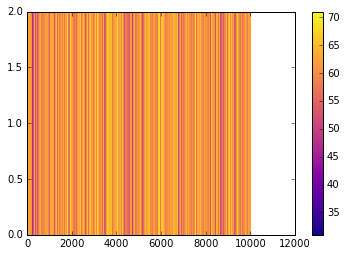

In [16]:
# Plot signifies areas of drastic change between cancer DNA and normal DNA
# 
# The x axis shows the 10000, 102-length nucleotide sequences and the y signifies
# the number of similarities between the 2; the cooler the color the greater the differences
# 
# This is a prelim product that could be used by researchers to detect genetic abnormalities
# from specific diseases to get treatment insight

from matplotlib import pyplot as plotter
axes = plt.pcolormesh([scores,scores],cmap='plasma')
plt.colorbar()